# Data analysis of the Brownian motion experiment

**Author: D.Kufel**

Experiments have been undertaken in Labs at UCL during December 2018. 

*Typically data parsing for this experiment is done manually: here I propose an automatic parser for the data which allows for increase in size of dataset for analysis by roughly two orders of magnitude.*

*Disclaimer: this code was written to solve the data anlysis problem using the simplest approach possible in a very limited time and not neccesairly is the most efficient one.*

## Abstract
In this notebook, quantitative properties of the Brownian motion such as mean square displacement and probability density function for ensemble of particles, were investigated. It was achieved by video tracking of the motion of the Polystyrene particles in a pure water solvent. Furthermore, we have found the value of the Boltzmann constant to be $k_b = (0.7 ± 0.1) \cdot 10^{-23}J/K$ which agrees (up to the order of magnitude) with the accepted value. We conclude that quantitative properties of the Brownian motion agree with its mathematical description.

## Introduction
During Brownian motion, microscopic particles immersed in a fluid undergo perpetual thermal motion continuously colliding with the molecules of the surrounding fluid. It is crucial to emphasize that this process occurs in the thermodynamic equilibrium. The concept of Brownian motion is crucial in branches of physics like optical-tweezers [1], astrophysics [2] or even mathematics [3]. It was shown that Brownian motion of the small particles to the first approximation depends proportionally to temperature and inversely proportionally to particle’s radius and (dynamic) viscosity of the medium. Trajectories of the microscopic particles can be modeled mathematically as a multi-dimensional random walk (assuming low Reynolds number regime - which is indeed the case for micron-sized particles immersed in the room-temperature water). As no direction in the motion of the particle is distinguished, its average displacement over time will be 0. However, we may consider more informative quantities describing Brown- ian motion: namely mean squared displacement (MSD). For ergodic systems we may write the MSD in a twofold way [4]:

$$ MSD_{ensemble} (h) = \langle {(x_h-x_0)}^2 \rangle = \overline{{(x_{i+h}-x_0)}^2} = MSD_{single} (h) = 2Dt \ \ \ \ \ \ \ \ \ \ \ \ \ (1)$$ 

where the second equality denotes average over ensemble of particles and third equality usesaverage over many step increments h for single particle’s track; $t=h \Delta t$ with $\Delta t$ being a timestep and $D$ is a diffusion constant which by fluctuation-dissipation theorem and Stokes’ law satisfies: $D=\frac{k_b T}{6 \pi \eta a}$ with $a$ being the radius of the particle, $T$ fluid's temperature and $\eta$ viscosity of the fluid.


Furthermore, there exists another mathematical description of the Brownian motion's dynamics - exploiting deterministic evolution of probability density distribution function $\rho(r,t)$ for ensemble of particles. This evolution is governed by the free diffusion equation (assuming lack of external forces) and should follow (assuming initial condition $\rho(r,0)=\delta(r)$ a Gaussian distribution with variance $\sigma^2=2Dt$ [4]:

$$ \rho(r,t)=\frac{1}{\sqrt{4\pi Dt}} exp\left(-\frac{r^2}{4Dt}\right) \ \ \ \ \ \ \ \ \ \ \ \ (2)$$

where $r$ is the position of a given particle with respect to its initial position and $t$ is time.

In the notebook, we investigate experimentally whether equations (1) and (2) hold for the Brownian motion of the spherical Polystyrene Latex microparticles. First, we describe experimental procedure and video processing methods. Second, we briefly present the results of the MSD calculations and probability distribution for ensemble of particles, along with calculation of the Boltzmann constant. Third, we discuss the results of the experiments employing single- particle tracking methods and the shape of the probability distribution function. Finally, we discuss possible sources of uncertainty affecting the accuracy of the Boltzmann constant measurement, exploiting a computational model of the Brownian motion.

## Experimental Methods

### Experimental procedure
Particles used during the experiments were Polystyrene latex microspheres (Sigma-Aldrich manufacturer) with a radius of 1.1 ± 0.1μm. They were dissolved in a pure water solution using method of serial dilution. The sample was put on the glass slide using reinforcement rings, covered by the #1.5 coverslips (170 ± 20μm thick) and put under the microscope (40x objec- tive, 0.65 160/0.17, VWR). Video recordings of the Brownian motion of the particles moving in the horizontal plane were obtained using Visi- cam software (60-second tracks, video uncompressed, in total 521 frames collected, 1024x768 resolution). Calibration slide was used to convert video resolution to real size of the image (1024 pixels ≈ 286 ± 3μm). The solution of latex microspheres was chosen such to see ≈ 200 particles on the one frame of the video.
### Video processing and particle tracking
Video recordings were processed using ImageJ programme. The following steps were taken to allow for automatic particle tracking: 1) Video was converted into grayscale. 2) Background of the image was subtracted assuming ball radius of
5 pixels and sliding paraboloid method 3) Gaus- sian blur of the image with σblur = 2.0 pixels was applied 4) Threshold was adjusted manu- ally by comparison of the programme’s predicted particle locations with the ones visible on the video 5) MTrack2 plugin for ImageJ was used to track the positions of the particles. In total 254 particles were tracked.
Output of the tracking was saved into file consisting particles’ positions over time. To generate twice as much of data, x and y positions of the Brownian particle’s motion were split into two strands of random walk (note that Eq. (1) and (2) describe one-dimensional walk) - thus constituting in total to 508 separate strands of random walks. Positions data was analyzed using Python (see Appendix A for details). Data analysis produced MSD calculated from an ensemble of particles, set of MSDs calculated from the single particle tracking (Eq. 1) and particles’ position probability distribution in dif- ferent moments of time (Eq. 2). Uncertainties in position tracking were found using previously reported methods [5]. Finally, the linear (weighted and unconstrained) fit to the ensemble MSD was performed. It was assumed that the weights of the fit were inversely proportional to the square of the uncertainties in the position. Moreover, propagation of uncertainties in the Boltzmann constant calculations were calculated using correlated error formula (for temperature and viscosity- estimated based on the correlation coefficient of −0.99 in range (10 − 30)◦C) and standard uncorrelated error formula (for the rest of the variables).

## Data analysis

*The main challenge for the data analysis was that an output format of a particle-tracking programme was not compatible with a standard way of loading the data*

Data analysis consisted the following, briefly described, steps: 

1) Data loading using pandas, 

2) Going through all rows and columns of the data 

3) Filtering the flags created by the ImageJ file 

4) Finding where the new set of data starts within a given column (as in ImageJ produced file in the same column there may be multiple sets of positions) 

5) Adding the numerical values of positions to an array consisting all positions of the particles in all times; if the values of posi- tions are not defined then appending the array with a NaN value. 

6) Filtering such sub-arrays which consist >100 numerical positions (not nan values) 

7) Finding the first index of not NaN value within a given subarray 

8) Masking the processed array to calculate mean over axis=0 to obtain MSD from the ensemble of particles.

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import scipy.stats as stats

In [2]:
df=pd.read_csv('testfrom91.csv')

datao=df[df.columns[0:1]].values

datafullpix=[]

numberrows=8 #arbitrary - JUST PROOF OF PRINICIPLE
for foo in range(1,numberrows):
    print('Going through the set of rows ',str(foo))
    for i in range(1,df.shape[1]-1):
        if i%3!=0: #to filter out the flags
            what=df[df.columns[i:i+1]].values

            columnsfull=[[]]
            counterx=0
            for j in range(0,(datao.shape[0])):
                if datao[j]=='1':
                    counterx+=1
                    columnsfull.append([])
                try:
                    columnsfull[counterx].append(float(what[j][0]))
                except:
                    columnsfull[counterx].append(np.nan)
                    continue

            #path length filter
            test= list(filter(lambda x: np.isnan(x)==False, columnsfull[foo]))
            if(len(test)>200): #note that if X exists then Y exists
                datafullpix.append(np.asarray(columnsfull[foo]))
                print('Brownian particle added...')

Going through the set of rows  1
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle adde

Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
Brownian particle added...
B

### Plotting the particle trajectories

<IPython.core.display.Javascript object>


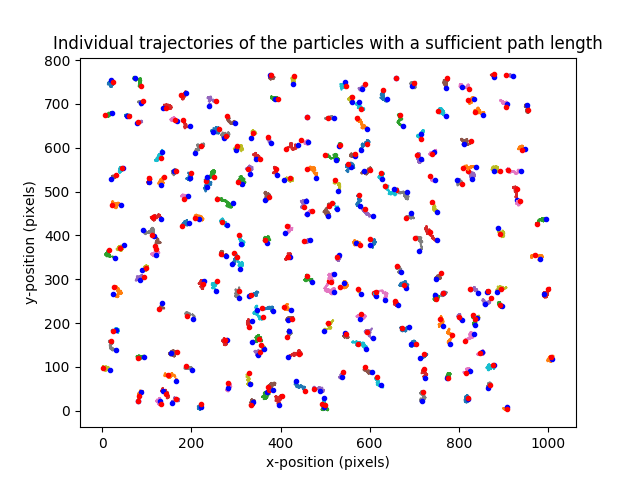

Numeber of particles with a sufficient path length:  414


In [3]:
plt.figure()
plt.title('Individual trajectories of the particles with a sufficient path length')
plt.xlabel('x-position (pixels)')
plt.ylabel('y-position (pixels)')
w=0
while(w<len(datafullpix)-1):
    plt.plot(datafullpix[w],datafullpix[w+1],linestyle='dashed')
    lastindex=np.argwhere(False==np.isnan(datafullpix[w]))[-1][0] #index of final point with value != nan
    plt.plot(datafullpix[w][0],datafullpix[w+1][0],'b.') #initial point
    plt.plot(datafullpix[w][lastindex],datafullpix[w+1][lastindex],'r.') #final point
    w+=2

print('Numeber of particles with a sufficient path length: ', w)

### Pixels to microns conversion

In [4]:
pixeltomicron=286/1024 #for 1024 px measured width was 286 microns

### Timeframe to seconds conversion

In [5]:
timex=np.linspace(0,60,len(datafullpix[0]))

## Ensemble-averaging

<IPython.core.display.Javascript object>


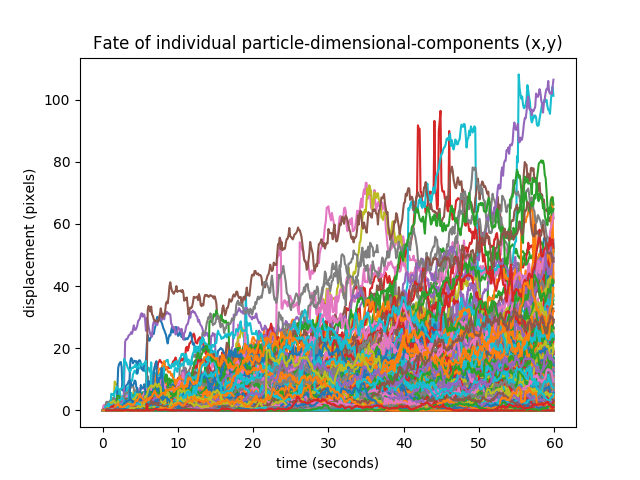

<IPython.core.display.Javascript object>


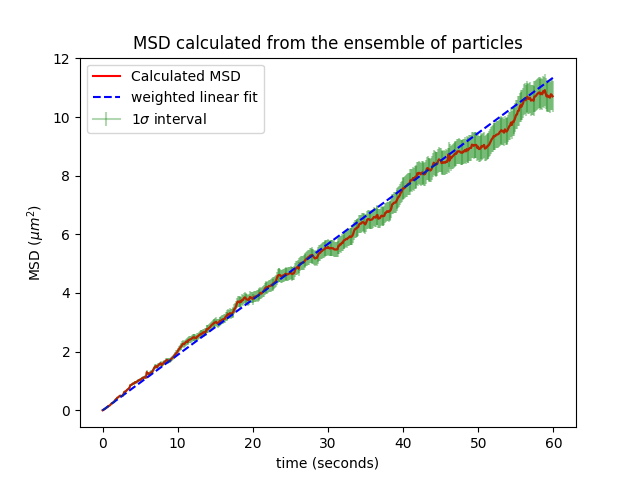

/Users/dsk/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


<ErrorbarContainer object of 3 artists>

In [6]:
datafullpaxromanum=np.asarray(datafullpix)
datafull=datafullpaxromanum*pixeltomicron#conversion from pixels to microns
squaredlist=[]
plt.figure()
plt.xlabel('time (seconds)')
plt.ylabel('displacement (pixels)')
plt.title('Fate of individual particle-dimensional-components (x,y)')
squaredarray=np.empty([len(datafull),len(datafull[1])])
notsquaredarray=np.empty([len(datafull),len(datafull[1])])


for k in range(0,len(datafull)):

    #finding first not nan index
    war=np.isnan(datafull[k])
    warlist=war.tolist()
    firstnotnanindex=warlist.index(False)
    
    squared=(datafull[k][:]-np.ones(len(datafull[k]))*datafull[k][firstnotnanindex])**2
    notsquared=(datafull[k][:]-np.ones(len(datafull[k]))*datafull[k][firstnotnanindex])
    plt.plot(timex,squared)
    squaredarray[k]=squared
    notsquaredarray[k]=notsquared
    

squaredmarray=np.ma.masked_array(squaredarray,np.isnan(squaredarray))

xxmean=np.mean(squaredmarray,axis=0)

plt.figure()
plt.xlabel('time (seconds)')
plt.ylabel('MSD (${\mu m}^2$)')
plt.title('MSD calculated from the ensemble of particles')
plt.plot(timex,xxmean,color='r',label='Calculated MSD')

fractionalerror=1/np.sqrt(len(datafull))
plt.errorbar(timex,xxmean,yerr=xxmean*fractionalerror,fmt='g',alpha=0.3,label='$1 \sigma$ interval')

By using the following equations:
$$ D=\frac{k_bT}{\gamma}$$
$$ \gamma = 6 \pi f a $$
$$ m = \frac{k_b T}{3 \pi f a} $$
where m is a coefficient of the linear fit and $ T \approx 291 K $ 
$$ MSD=2Dt$$ 
we conclude:

$$ k_b = \frac{3 \pi f a m}{T} $$

### Line Fitting

In [7]:
y=xxmean
x=timex
yerr=fractionalerror*xxmean
w=1/(yerr**(2)) #defining the weight
delta = (np.sum(w))*(np.sum(w*x**2))-(np.sum(w*x))**2 #delta - defined above
nominator = np.sum(w)*np.sum(w*x*y)-np.sum(w*x)*np.sum(w*y) #nominator of equation (9)

m_weight = nominator/delta #the slope of the weighted fit line
deltaM_weight=np.sqrt(np.sum(w)/delta) #uncertainty of the slope
print("m_weight = {0:0.4f} +- {1:0.4f} microns^2/s".format(m_weight,deltaM_weight))
c_weight = (np.sum(w*(x**2))*np.sum(w*y)-(np.sum(w*x)*np.sum(w*x*y)))/delta
deltaC_weight=np.sqrt(np.sum((x**2)*w)/delta)
print("c_weight = {0:0.3f} +- {1:0.3f} [microns^2]".format(c_weight,deltaC_weight))
y_weighted_fit = m_weight*x+c_weight
plt.plot(x,y_weighted_fit,'b--',label='weighted linear fit') # plotting weighted fit
plt.legend()

m_weight = 0.1893 +- 0.0004 microns^2/s
c_weight = -0.004 +- 0.001 [microns^2]


The ensemble MSD of the set of particles was found to follow the linear trend and was shown with the fitted line above.

### Calculation of the Boltzmann's Constant

In [8]:
viscosity=1.0526*1e-3 #Pa*s?
radius=1.1*1e-6 #meters
Temperature=291 #kelvins

m_weight_units=m_weight*(1e-6)**2 #m^2/s
k_b=3*np.pi*viscosity*radius*m_weight_units/(Temperature)
print(k_b)

7.098833768153963e-24


Based on the slope m = 0.188 ± 0.005μm2/s of the line fitted to the MSD graph,temperature of the sample T = 291 ± 3K, dynamic viscosity of the water η = 1.08±0.07cP (for T = 291±3K) and particle radius a = 1.1 ± 0.1μm (uncer- tainty in particles’ radius based on the manu- facturer specification [6]), Boltzmann constant $k_b$ was found to be:

$$ k_b = (0.7 ± 0.1) · 10^{−23} J/K$$

The measured value of the Boltzmann constant is approximately two times smaller than the ac- cepted value [7], however, it is of the same order of magnitude. Moreover, the accepted value does not lie within the range of the estimated experimental uncertainty. To understand why such result may be the case we discuss below the possible causes of the discrepancy.

## Discussion
### Probability distribution view

Technical aside: using
https://stackoverflow.com/questions/19090070/pylab-histogram-get-rid-of-nan to ged rid of nan values in the histogram

<IPython.core.display.Javascript object>


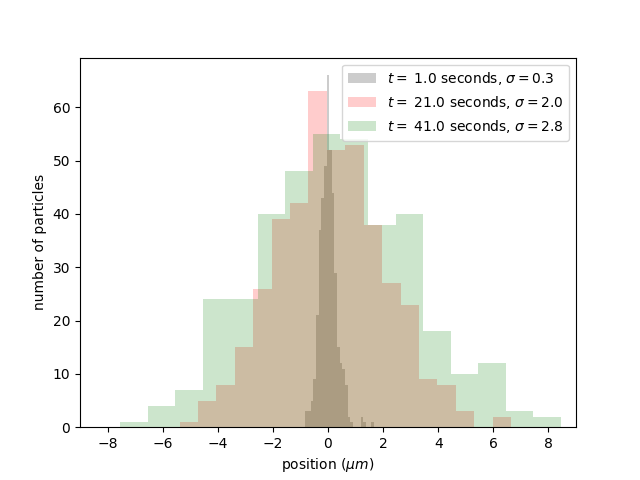

0.018950513775192183
0.14102474793789543
0.2830017953068461


(-9, 9)

In [9]:
plt.figure()
plt.xlabel('position ($\mu m$)')
plt.ylabel('number of particles')
setofcolors=['k','r','g','y']
runnumber=0
#e.g. nice for t=5,185,365 frames for test91 and number of rows 10
for i in range(5,len(datafull[1]),174): #arbitrary that 1, it's used because it's max length for the set used
    x0, sigma = stats.norm.fit(notsquaredarray[:,i][~np.isnan(notsquaredarray[:,i])])
    print(x0) #' ($\mu m$)'+'$, \mu= $'+str(round(x0,1))+' ($\mu m$)'
    plt.hist(notsquaredarray[:,i][~np.isnan(notsquaredarray[:,i])],bins='auto',ls='dashed', lw=0.5, alpha=0.2,color=setofcolors[runnumber],label='$t=$ '+str(round(i*60/512,0))+' seconds, '+'$\sigma= $'+str(round(sigma,1)))
    runnumber+=1

plt.legend()
plt.xlim(-9,9)

It was found that positions’ probability distribution to a good approximation follows Gaussian distribution.

It is crucial to note that, as expected by the Eq. 2. $\sigma^2$ of the normal probability distribution increases (approximately in the linear fashion) with time. However, it was found that the mean of the normal probability distribution is non-zero and slowly increases over time (see next Figure). This most probably could be explained by the not (ideally) normal position of the microscope w.r.t ground so that there could be a small component of the gravity pointing in some direction within the sample - acting as a drifting force - so that the mean displacement of the particles is no longer equal to $0$. The existence of the drift force should slightly increase the slope of the MSD curve for ensemble of particles, thus accounting for this unwanted behavior would further decrease the value of the calculated Boltzmann constant.

### Fitting Gaussian to the histogram

0.23568257714633795 2.9077932649373386


<IPython.core.display.Javascript object>


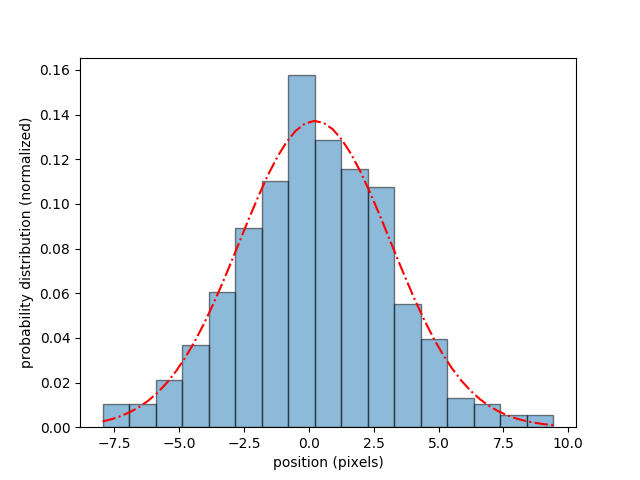

/Users/dsk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


Text(0, 0.5, 'probability distribution (normalized)')

In [10]:
sn=400 #selected number
x0, sigma = stats.norm.fit(notsquaredarray[:,sn][~np.isnan(notsquaredarray[:,sn])])
print(x0,sigma)
length_notsquaredarray=len(notsquaredarray[:,sn][~np.isnan(notsquaredarray[:,sn])])
x=np.linspace(min(notsquaredarray[:,sn][~np.isnan(notsquaredarray[:,sn])]),max(notsquaredarray[:,sn][~np.isnan(notsquaredarray[:,sn])]))
gaussian_check = stats.norm.pdf(x,x0,sigma)

plt.figure()
plt.hist(notsquaredarray[:,sn][~np.isnan(notsquaredarray[:,sn])],normed='True', bins='auto', edgecolor='k', lw=1, alpha=0.5) #or density='True' for newer matplotlib versions
plt.plot(x,gaussian_check,'r-.', label="stats.norm.pdf")
plt.xlabel('position (pixels)')
plt.ylabel('probability distribution (normalized)')

As the density of the Polystyrene Latex particles is larger than the density of the water, particles should sink in the water sample and occupy the bottom plane of the sample. Thus, it may be the case that particles’ diffusion coefficients are affected by the hydrodynamic interactions (especially that solvent does not consist any isopropyl alcohol). After taking into account hydrodynamic interactions, diffusion coefficient (in the horizontal direction) of the particles may be approximated by the following equation [9]:
$$D(h) \approx D_{\infty}\left(1-\frac{9R}{16h}\right)$$
assuming $d > 3a$, where d is the distance of the particle from the bottom of the sample.
Accounting for the existence of the diffusion gradient should shift the measured value of the Boltzmann constant slightly upwards, dependent on how close the particles were to the bottom of the sample.

### Other uncertainties estimation

1) Note that there is an uncertainty in pixel to micron conversion of order of about $286/283 \approx 1.01 $ ---> 1%

2) There is an uncertainty in temperature measurements: temperature should be between 288 K and 294 K ---> mean 291 K. The corollary of this is that there is an uncertainty in dynamic viscosity value: 

| Temperature (C)| Dynamic Viscosity (cP) |
|------|------|
|   15	| 1.1375|
|   16  | 1.1081|
|   17  | 1.0798|
|   18  | 1.0526|
|   19  | 1.0266|
|   20  | 1.0016|
|   21  | 0.9775|

3) As diffusion coefficient is dependent on the size of the particles and particles have certain size distribution around the mean value then this will introduce the source of uncertainty to the diffusion coefficient calculation. The manufacturer [6] suggests that particles should be 1.0 - 1.2 micron sized  Assuming that it is one sigma then for measurments we should have 0.1 micron uncertainty for the particle size 

4) There are few (less than 10) stuck particles (look at single particle tracking) which decrease the value of the diffusion constant. 

5) There are few (less than 5) particles which were subject to some gradient forces and thus there single particle MSD may look more like exponential and thus increasing the diffusion constant. 

6) In the video recordings, it is visible that particles were not ideally spherical and sometimes they were interfering with each other which is not accounted in the Stoke’s law used to derive fluctuation-dissipation theorem. Furthermore, during the time of the video recording, particles were constantly moving in and out of the focus of the microscope (result of their vertical motion within the sample) and thus this may reduce the accuracy of the particle tracking (though the influence of this factor is reduced by applying Gaussian blur during video processing). It is difficult to predict how these factors could influence the measured value of the Boltzmann constant.

In [11]:
corrcoeff=-0.99 #for 10-30 C range
deltaradius=0.2*1e-6 #meters
deltam=0.01 #microns squared per second
#purely due to pixelmicron conversion is 0.005 thus additionally 0
deltaviscosity=0.08*1e-3 #cP
deltaTemperature=3 #kelvins
deltakbfrac=np.sqrt((deltaradius/radius)**2+(deltam/m_weight)**2+(deltaTemperature/Temperature)**2+(deltaviscosity/viscosity)**2+2*(deltaTemperature/Temperature)*(deltaviscosity/viscosity)*corrcoeff)

print((deltaradius/radius),(deltam/m_weight),(deltaTemperature/Temperature),(deltaviscosity/viscosity))

print(deltakbfrac)

print(k_b,deltakbfrac*k_b)


0.1818181818181818 0.05282593379646425 0.010309278350515464 0.07600228006840205
0.2004486756480423
7.098833768153963e-24 1.4229518274720637e-24


Calculating predicted sizes of the uncertainties it seems that the dominant uncertainty is the one in the particle size distribution. Furthermore, it was found that it is possible to reproduce the results of the experiments using the computational simulation (not included in this notebook) of the Brownian motion if we assume that the mean radius of the particles is about 1.6 times larger than the one reported by the manufacturer [6] (keeping other parameters to be the same).

## Future experiments

In the future, it would be useful to use a larger magnification of the microscope to improve the efficiency of the particle tracking. Furthermore, it would be interesting to investigate water- ethanol mixtures as it was reported [8] that this may lead to micro-sized inhomogeneities in the mixture affecting fluid’s viscosity and thus particles’ diffusion constant.

### Conclusions
In this paper, measurements of some quanti- tative properties of the Brownian were taken. Furthermore, value of the Boltzmann constant was found to be $k_b = (0.7 \pm 0.1) \cdot 10^{−23} J/K$, which is of the same order of magnitude as expected value. Furthermore, possible sources of uncertainties in the experiment were identified.

## References

[1]  Ashkin, A., Dziedzic, J. M., Bjorkholm, J. E., & Chu, S. (1986). Observation of a single-beam gradient force optical trap for dielectric particles. Optics letters, 11(5), 288-290.

[2] Kempf, S., Pfalzner, S., & Henning, T. K. (1999). N-particle-simulations of dust growth: I. growth driven by Brownian Mo- tion. Icarus, 141(2), 388-398.

[3] Gajda, J., & Wylomanska, A. (2012). Geometric Brownian motion with tempered stable waiting times. Journal of Statistical Physics, 148(2), 296-305.

[4] Jones, P. H., Marago, O. M., & Volpe, G. (2015). Optical tweezers: Principles and applications. Cambridge University Press.

[5] Catipovic, M. A., Tyler, P. M., Trapani, J. G., & Carter, A. R. (2013). Improving the quantification of Brownian motion. Ameri- can Journal of Physics, 81(7), 485-491.

[6] Sigma-Aldrich Manufacturer, 1.1μm Latex Beads specification

[7] Pitre, L., Sparasci, F., Truong, D., Guillou, A., Risegari, L., & Himbert, M. E. (2011). Measurement of the Boltzmann constant k B using a quasi-spherical acoustic resonator. International Journal of Thermophysics, 32(9), 1825.

[8] Furukawa, K., & Judai, K. (2017). Brownian motion probe for water-ethanol inhomogeneous mixtures. The Journal of Chemical Physics, 147(24), 244502.

[9] Faxen, H. (1922). Der Widerstand gegen die Bewegung einer starren Kugel in einer zahen Flussigkeit, die zwischen zwei par- allelen ebenen Wanden eingeschlossen ist. Annalen der Physik, 373(10), 89-119.